In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tabulate import tabulate
from fairlearn.metrics import equalized_odds_difference

In [127]:
# Load datasets
path = "pums_random_error2080_nativity_ver1_newFDs/"
clean_path = path + '6000_0.05_clean.csv'
dirty_path = path + '6000_0.05_dirty.csv'
repaired_path = path + "6000_0.05_repaired.csv"
# clean_path = path + '4000_0.05_clean.csv'
# dirty_path = path + '4000_0.05_dirty.csv'
# repaired_path = path + "4000_0.05_repaired.csv"

clean_df = pd.read_csv(clean_path)
dirty_df = pd.read_csv(dirty_path)
repaired_df = pd.read_csv(repaired_path)

clean_df = clean_df.drop("ID", axis=1)
dirty_df = dirty_df.drop("ID", axis=1)
# repaired_df["ID"] = dirty_df["ID"]
repaired_df = repaired_df.drop("_tid_", axis=1)
# Display basic info about the datasets
# print('Clean Data Info:')
# print(clean_df.info())
# print('\nDirty Data Info:')
# print(dirty_df.info())

# Check the first few rows of the datasets
# print('\nClean Data Sample:')
# print(clean_df.head())
# print('\nDirty Data Sample:')
# print(dirty_df.head())

In [3]:
# def combineRaces(df):
#     combined_races = [3, 4, 5, 7]
#     for i in range(len(df)):
#         if df.loc[i, 'RAC1P'] in combined_races:
#             df.loc[i, "RAC1P"] = 10
#     return df

In [183]:
dirty_df

,RAC1P,SEX,REGION,ST,CIT,NATIVITY,DIS,DIVISION,RAC2P,POBP,WAOB
0,4,2,4,6,4,2,2,9,45,233,4
1,6,1,1,36,4,2,2,2,43,207,4
2,6,1,9,51,4,2,1,5,20,238,4
3,2,1,4,6,4,2,2,9,68,314,3
4,9,1,4,6,4,2,2,9,45,233,4
...,...,...,...,...,...,...,...,...,...,...,...
5995,2,1,3,48,1,1,1,7,2,48,1
5996,1,1,4,16,1,1,2,8,1,16,1
5997,1,1,3,1,1,1,2,6,1,1,1
5998,1,1,4,6,1,1,2,9,1,6,1


In [128]:
# Prepare Data: target variable y is the binary classification of NATIVITY (whether a person is Native or Foreign-born)
# The sensitive attribute RAC1P (likely race or ethnicity) is separated out to evaluate fairness
def prepare_data(df, is_clean=True,):
    if is_clean:
        df = df.iloc[:, :-8] # Dropping the last 8 columns of the clean dataset
    X_with_sensitive = df.drop(['NATIVITY'], axis=1)
    y = (df['NATIVITY'] == 1).astype(int) # Binary classification: 1 if Native, 0 if Foreign-born
    
    #recode any in combined_races to be 10
    combined_races = [3, 4, 5, 7]
    for i in range(len(df)):
        if X_with_sensitive.loc[i, 'RAC1P'] in combined_races:
            X_with_sensitive.loc[i, "RAC1P"] = 10
    sensitive_attr = X_with_sensitive["RAC1P"]
    X = X_with_sensitive.drop("RAC1P", axis=1)
#     if is_repair:
#         return X, y, sensitive_attr
    X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(X, y, sensitive_attr, test_size=0.2, stratify=y, random_state=40)
    return X_train, X_test, y_train, y_test, s_train, s_test

In [129]:
# Prepare training and testing sets: data is split into training and testing sets, along with the sensitive attribute.
X_train_clean, X_test_clean, y_train_clean, y_test_clean, s_train_clean, s_test_clean = prepare_data(clean_df, is_clean=True)
X_train_dirty, X_test_dirty, y_train_dirty, y_test_dirty, s_train_dirty, s_test_dirty = prepare_data(dirty_df, is_clean=False)

X_train_repaired, X_test_repaired, y_train_repaired, y_test_repaired, s_train_repaired, s_test_repaired = prepare_data(repaired_df, is_clean=False)
# X_repaired, y_repaired, s_repaired = prepare_data(repaired_df, is_clean=False, is_repair=True)

In [6]:
# X_train_clean_c = X_train_clean_c.drop("RAC1P", axis=1)
# X_test_clean_c = X_test_clean_c.drop("RAC1P", axis=1)
# X_test_clean_d = X_test_clean_d.drop("RAC1P", axis=1)

# X_train_dirty_d = X_train_dirty_d.drop("RAC1P", axis=1)
# X_test_dirty_c = X_test_dirty_c.drop("RAC1P", axis=1)
# X_test_dirty_d = X_test_dirty_d.drop("RAC1P", axis=1)

# X_test_clean_c

In [7]:
# # Prepare Data: target variable y is the binary classification of NATIVITY (whether a person is Native or Foreign-born)
# # The sensitive attribute RAC1P (likely race or ethnicity) is separated out to evaluate fairness
# clean_df = clean_df.iloc[:, :-8]

# X_clean = clean_df.drop("NATIVITY", axis=1)
# y_clean = (clean_df['NATIVITY'] == 1).astype(int)
# X_clean = combineRaces(X_clean)
# X_train_clean_c, X_test_clean_c, y_train_clean_c, y_test_clean_c= train_test_split(X_clean, y_clean, test_size=0.2, stratify=y_clean, random_state=40) # clean data used to train (and test) the clean scaler
# X_train_clean_d, X_test_clean_d, y_train_clean_d, y_test_clean_d= train_test_split(X_clean, y_clean, test_size=0.2, stratify=y_clean, random_state=40) # clean data used to test the dirty scaler (NOT TRAIN)

# X_dirty = dirty_df.drop("NATIVITY", axis=1)
# y_dirty = (dirty_df['NATIVITY'] == 1).astype(int)
# X_dirty = combineRaces(X_dirty)
# X_train_dirty_c, X_test_dirty_c, y_train_dirty_c, y_test_dirty_c= train_test_split(X_dirty, y_dirty, test_size=0.2, stratify=y_dirty, random_state=40) # dirty data used to test the clean scaler (NOT TRAIN)
# X_train_dirty_d, X_test_dirty_d, y_train_dirty_d, y_test_dirty_d= train_test_split(X_dirty, y_dirty, test_size=0.2, stratify=y_dirty, random_state=40) # dirty data used to train (and test) the dirty scaler

# cols = X_train_clean_c.columns

# X_repaired = repaired_df.drop("NATIVITY", axis=1)
# y_clean = (repaired_df['NATIVITY'] == 1).astype(int)
# X_repaired_c = combineRaces(X_repaired.copy())
# X_repaired_d = combineRaces(X_repaired.copy())

# # clean_scaler = StandardScaler()
# clean_scaler = MinMaxScaler()
# clean_scaler.fit(X_train_clean_c, y_train_clean_c)
# X_train_clean_c = pd.DataFrame(clean_scaler.transform(X_train_clean_c),columns=cols) 
# X_test_dirty_c = pd.DataFrame(clean_scaler.transform(X_test_dirty_c), columns = cols)
# X_repaired_c = pd.DataFrame(clean_scaler.transform(X_repaired_c), columns=cols)

# # dirty_scaler = StandardScaler()
# dirty_scaler = MinMaxScaler()
# dirty_scaler.fit(X_train_dirty_d, y_train_dirty_d)
# X_train_dirty_d = pd.DataFrame(dirty_scaler.transform(X_train_dirty_d),columns=cols) 
# X_test_clean_d = pd.DataFrame(dirty_scaler.transform(X_test_clean_d),columns=cols) 
# X_repaired_d = pd.DataFrame(dirty_scaler.transform(X_repaired_d),columns=cols) 

# s_train_clean_c = X_train_clean_c["RAC1P"]
# # s_train_clean_d = X_train_clean_d["RAC1P"]
# s_test_clean_c = X_test_clean_c["RAC1P"]
# s_test_clean_d = X_test_clean_d["RAC1P"]

# # s_train_dirty_c = X_train_dirty_c["RAC1P"]
# s_train_dirty_d = X_train_dirty_d["RAC1P"]
# s_test_dirty_c = X_test_dirty_c["RAC1P"]
# s_test_dirty_d = X_test_dirty_d["RAC1P"]

# X_train_clean_c = X_train_clean_c.drop("RAC1P", axis=1)
# X_test_clean_c = X_test_clean_c.drop("RAC1P", axis=1)
# X_test_clean_d = X_test_clean_d.drop("RAC1P", axis=1)

# X_train_dirty_d = X_train_dirty_d.drop("RAC1P", axis=1)
# X_test_dirty_c = X_test_dirty_c.drop("RAC1P", axis=1)
# X_test_dirty_d = X_test_dirty_d.drop("RAC1P", axis=1)

# s_repaired_c= X_repaired_c["RAC1P"]
# s_repaired_d = X_repaired_d["RAC1P"]

# X_repaired_c = X_repaired_c.drop("RAC1P", axis=1)
# X_repaired_d = X_repaired_d.drop("RAC1P", axis=1)

In [153]:
# Fairness Metrics
def demographic_parity(y_pred, sensitive_attr): # Measures whether the prediction rates are equal across different race groups
    groups = sensitive_attr.unique()
    rates = {group: (y_pred[sensitive_attr == group].mean()) for group in groups}
    return rates

def average_demographic_parity(dictionary):
    return np.mean(list(dictionary.values()))

def tpr_max_diff(tup):
    dictionary = tup[0]
    return max(list(dictionary.values())) - min(list(dictionary.values()))
    
def fpr_max_diff(tup):
    dictionary = tup[1]
    return max(list(dictionary.values())) - min(list(dictionary.values()))

def demographic_parity_difference(dictionary):
    return max(list(dictionary.values())) - min(list(dictionary.values()))

# def equalized_odds_diff(tup):
#     tpr, fpr = tup
#     keys = tpr.keys()
#     diff = {}
#     for k in keys:
#         diff[k] = (tpr[k]-fpr[k])
#     maxkey = max(diff, key=diff.get)
#     return maxkey, diff[maxkey]

def equalized_odds(y_true, y_pred, sensitive_attr): # Measures whether true positive rates and false positive rates are equal across race groups
    groups = sensitive_attr.unique()
    true_positive_rates = {}
    false_positive_rates = {}

    for group in groups:
        y_true_group = y_true[sensitive_attr == group]
        y_pred_group = y_pred[sensitive_attr == group]
        
        tp = ((y_pred_group == 1) & (y_true_group == 1)).sum()
        tn = ((y_pred_group == 0) & (y_true_group == 0)).sum()
        fp = ((y_pred_group == 1) & (y_true_group == 0)).sum()
        fn = ((y_pred_group == 0) & (y_true_group == 1)).sum()
        
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        true_positive_rates[group] = tpr
        false_positive_rates[group] = fpr

    return true_positive_rates, false_positive_rates

def disparate_impact_ratio(y_pred, sensitive_attr): # Ratio of the minimum prediction rate to the maximum prediction rate across groups
    groups = sensitive_attr.unique()
    rates = {group: (y_pred[sensitive_attr == group].mean()) for group in groups}
    min_rate = min(rates.values())
    max_rate = max(rates.values())
    return min_rate / max_rate if max_rate > 0 else 0

def statistical_parity_difference(y_pred, sensitive_attr): # Difference between the maximum and minimum prediction rates across groups
    groups = sensitive_attr.unique()
    rates = {group: (y_pred[sensitive_attr == group].mean()) for group in groups}
    max_rate = max(rates.values())
    min_rate = min(rates.values())
    return max_rate - min_rate

In [131]:
# logreg_train_clean = LogisticRegression(max_iter=1000, random_state=42)
# logreg_train_clean.fit(X_train_clean_c, y_train_clean_c)
# y_pred_logreg_train_clean_test_clean = logreg_train_clean.predict(X_test_clean_c)
# y_pred_logreg_train_clean_test_dirty = logreg_train_clean.predict(X_test_dirty_c)

# logreg_train_dirty = LogisticRegression(max_iter=1000, random_state=42)
# logreg_train_dirty.fit(X_train_dirty_d, y_train_dirty_d)
# y_pred_logreg_train_dirty_test_clean = logreg_train_dirty.predict(X_test_clean_d)
# y_pred_logreg_train_dirty_test_dirty = logreg_train_dirty.predict(X_test_dirty_d)

# # repaired below
# y_pred_logreg_train_clean_test_repaired = logreg_train_clean.predict(X_repaired_c)
# y_pred_logreg_train_dirty_test_repaired = logreg_train_dirty.predict(X_repaired_d)

    
logreg_train_clean = LogisticRegression(max_iter=500, random_state=42)
logreg_train_clean.fit(X_train_clean, y_train_clean)
y_pred_logreg_train_clean_test_clean = logreg_train_clean.predict(X_test_clean)
y_pred_logreg_train_clean_test_dirty = logreg_train_clean.predict(X_test_dirty)

logreg_train_dirty = LogisticRegression(max_iter=5000, random_state=42)
logreg_train_dirty.fit(X_train_dirty, y_train_dirty)
y_pred_logreg_train_dirty_test_clean = logreg_train_dirty.predict(X_test_clean)
y_pred_logreg_train_dirty_test_dirty = logreg_train_dirty.predict(X_test_dirty)

# repaired below
y_pred_logreg_train_clean_test_repaired = logreg_train_clean.predict(X_test_repaired)
y_pred_logreg_train_dirty_test_repaired = logreg_train_dirty.predict(X_test_repaired)


#adding repaired/repaired
logreg_train_repaired = LogisticRegression(max_iter=5000, random_state=42)
logreg_train_repaired.fit(X_train_repaired, y_train_repaired)
y_pred_logreg_train_repaired_test_repaired = logreg_train_repaired.predict(X_test_repaired)


In [132]:
# tree_train_clean = DecisionTreeClassifier(random_state=42)
# tree_train_clean.fit(X_train_clean_c, y_train_clean_c)
# y_pred_tree_train_clean_test_clean = tree_train_clean.predict(X_test_clean_c)
# y_pred_tree_train_clean_test_dirty = tree_train_clean.predict(X_test_dirty_c)

# tree_train_dirty = DecisionTreeClassifier(random_state=42)
# tree_train_dirty.fit(X_train_dirty_d, y_train_dirty_d)
# y_pred_tree_train_dirty_test_clean = tree_train_dirty.predict(X_test_clean_d)
# y_pred_tree_train_dirty_test_dirty = tree_train_dirty.predict(X_test_dirty_d)

# #repaired below
# y_pred_tree_train_clean_test_repaired = tree_train_clean.predict(X_repaired_c)
# y_pred_tree_train_dirty_test_repaired = tree_train_dirty.predict(X_repaired_d)

tree_train_clean = DecisionTreeClassifier(random_state=42)
tree_train_clean.fit(X_train_clean, y_train_clean)
y_pred_tree_train_clean_test_clean = tree_train_clean.predict(X_test_clean)
y_pred_tree_train_clean_test_dirty = tree_train_clean.predict(X_test_dirty)

tree_train_dirty = DecisionTreeClassifier(random_state=42)
tree_train_dirty.fit(X_train_dirty, y_train_dirty)
y_pred_tree_train_dirty_test_clean = tree_train_dirty.predict(X_test_clean)
y_pred_tree_train_dirty_test_dirty = tree_train_dirty.predict(X_test_dirty)

#repaired below
y_pred_tree_train_clean_test_repaired = tree_train_clean.predict(X_test_repaired)
y_pred_tree_train_dirty_test_repaired = tree_train_dirty.predict(X_test_repaired)

#adding repaired/repaired
tree_train_repaired = DecisionTreeClassifier(random_state=42)
tree_train_repaired.fit(X_train_repaired, y_train_repaired)
y_pred_tree_train_repaired_test_repaired = tree_train_repaired.predict(X_test_repaired)


In [133]:
# rf_train_clean = RandomForestClassifier(random_state=42)
# rf_train_clean.fit(X_train_clean_c, y_train_clean_c)
# y_pred_rf_train_clean_test_clean = rf_train_clean.predict(X_test_clean_c)
# y_pred_rf_train_clean_test_dirty = rf_train_clean.predict(X_test_dirty_c)

# rf_train_dirty = RandomForestClassifier(random_state=42)
# rf_train_dirty.fit(X_train_dirty_d, y_train_dirty_d)
# y_pred_rf_train_dirty_test_clean = rf_train_dirty.predict(X_test_clean_d)
# y_pred_rf_train_dirty_test_dirty = rf_train_dirty.predict(X_test_dirty_d)

# #repaired below
# y_pred_rf_train_clean_test_repaired = rf_train_clean.predict(X_repaired_c)
# y_pred_rf_train_dirty_test_repaired = rf_train_dirty.predict(X_repaired_d)

rf_train_clean = RandomForestClassifier(random_state=42)
rf_train_clean.fit(X_train_clean, y_train_clean)
y_pred_rf_train_clean_test_clean = rf_train_clean.predict(X_test_clean)
y_pred_rf_train_clean_test_dirty = rf_train_clean.predict(X_test_dirty)

rf_train_dirty = RandomForestClassifier(random_state=42)
rf_train_dirty.fit(X_train_dirty, y_train_dirty)
y_pred_rf_train_dirty_test_clean = rf_train_dirty.predict(X_test_clean)
y_pred_rf_train_dirty_test_dirty = rf_train_dirty.predict(X_test_dirty)

#repaired below
y_pred_rf_train_clean_test_repaired = rf_train_clean.predict(X_test_repaired)
y_pred_rf_train_dirty_test_repaired = rf_train_dirty.predict(X_test_repaired)

#adding repaired/repaired
rf_train_repaired = RandomForestClassifier(random_state=42)
rf_train_repaired.fit(X_train_repaired, y_train_repaired)
y_pred_rf_train_repaired_test_repaired = rf_train_repaired.predict(X_test_repaired)

In [151]:
# svm_train_clean = SVC(kernel="linear", max_iter=10000, random_state=42)
# svm_train_clean.fit(X_train_clean_c, y_train_clean_c)
# y_pred_svm_train_clean_test_clean = svm_train_clean.predict(X_test_clean_c)
# y_pred_svm_train_clean_test_dirty = svm_train_clean.predict(X_test_dirty_c)

# svm_train_dirty = SVC(kernel="linear", max_iter=10000, random_state=42)
# svm_train_dirty.fit(X_train_dirty_d, y_train_dirty_d)
# y_pred_svm_train_dirty_test_clean = svm_train_dirty.predict(X_test_clean_d)
# y_pred_svm_train_dirty_test_dirty = svm_train_dirty.predict(X_test_dirty_d)

# #repaired below
# y_pred_svm_train_clean_test_repaired = svm_train_clean.predict(X_repaired_c)
# y_pred_svm_train_dirty_test_repaired = svm_train_dirty.predict(X_repaired_d)

svm_train_clean = SVC(kernel="linear", max_iter=100000, random_state=42)
svm_train_clean.fit(X_train_clean, y_train_clean)
y_pred_svm_train_clean_test_clean = svm_train_clean.predict(X_test_clean)
y_pred_svm_train_clean_test_dirty = svm_train_clean.predict(X_test_dirty)

svm_train_dirty = SVC(kernel="linear", max_iter=100000, random_state=42)
svm_train_dirty.fit(X_train_dirty, y_train_dirty)
y_pred_svm_train_dirty_test_clean = svm_train_dirty.predict(X_test_clean)
y_pred_svm_train_dirty_test_dirty = svm_train_dirty.predict(X_test_dirty)

#repaired below
y_pred_svm_train_clean_test_repaired = svm_train_clean.predict(X_test_repaired)
y_pred_svm_train_dirty_test_repaired = svm_train_dirty.predict(X_test_repaired)

#adding repaired/repaired
svm_train_repaired = SVC(kernel="linear", max_iter=100000, random_state=42)
svm_train_repaired.fit(X_train_repaired, y_train_repaired)
y_pred_svm_train_repaired_test_repaired = svm_train_repaired.predict(X_test_repaired)

C:\Users\miche\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\miche\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [13]:
#Predictions for all 4 models (each trained on the clean/dirty data) on all of the repaired data!



# preds = [y_pred_logreg_train_clean_test_repaired, y_pred_logreg_train_dirty_test_repaired, y_pred_tree_train_clean_test_repaired, y_pred_tree_train_dirty_test_repaired, y_pred_rf_train_clean_test_repaired, y_pred_rf_train_dirty_test_repaired, y_pred_svm_train_clean_test_repaired, y_pred_svm_train_dirty_test_repaired]


In [135]:
# print('Logistic Regression Accuracy (Train: Clean, Test: Clean):', accuracy_score(y_test_clean_c, y_pred_logreg_train_clean_test_clean))
# print('Logistic Regression Accuracy (Train: Clean, Test: Dirty):', accuracy_score(y_test_dirty_c, y_pred_logreg_train_clean_test_dirty))
# print('Logistic Regression Accuracy (Train: Dirty, Test: Clean):', accuracy_score(y_test_clean_d, y_pred_logreg_train_dirty_test_clean))
# print('Logistic Regression Accuracy (Train: Dirty, Test: Dirty):', accuracy_score(y_test_dirty_d, y_pred_logreg_train_dirty_test_dirty))

# print("-------------------------------Repaired Data Results--------------------------------")
# print('Logistic Regression Accuracy (Train: Clean, Test: Repaired):', accuracy_score(y_repaired_c, y_pred_logreg_train_clean_test_repaired))
# print('Logistic Regression Accuracy (Train: Dirty, Test: Repaired):', accuracy_score(y_repaired_d, y_pred_logreg_train_dirty_test_repaired))

logreg_accuracies = [accuracy_score(y_test_clean, y_pred_logreg_train_clean_test_clean), accuracy_score(y_test_dirty, y_pred_logreg_train_clean_test_dirty), accuracy_score(y_test_clean, y_pred_logreg_train_dirty_test_clean), accuracy_score(y_test_dirty, y_pred_logreg_train_dirty_test_dirty), accuracy_score(y_test_repaired, y_pred_logreg_train_clean_test_repaired), accuracy_score(y_test_repaired, y_pred_logreg_train_dirty_test_repaired), accuracy_score(y_test_repaired, y_pred_logreg_train_repaired_test_repaired)]
logreg_accuracies = [round(x, 4) for x in logreg_accuracies]
print('Logistic Regression Accuracy (Train: Clean, Test: Clean):', logreg_accuracies[0])
print('Logistic Regression Accuracy (Train: Clean, Test: Dirty):', logreg_accuracies[1])
print('Logistic Regression Accuracy (Train: Clean, Test: Repaired):', logreg_accuracies[4])
print('Logistic Regression Accuracy (Train: Dirty, Test: Clean):', logreg_accuracies[2])
print('Logistic Regression Accuracy (Train: Dirty, Test: Dirty):', logreg_accuracies[3])
print('Logistic Regression Accuracy (Train: Dirty, Test: Repaired):', logreg_accuracies[5])
print('Logistic Regression Accuracy (Train: Repaired, Test: Repaired):', logreg_accuracies[6])

Logistic Regression Accuracy (Train: Clean, Test: Clean): 1.0
Logistic Regression Accuracy (Train: Clean, Test: Dirty): 0.9233
Logistic Regression Accuracy (Train: Clean, Test: Repaired): 0.9458
Logistic Regression Accuracy (Train: Dirty, Test: Clean): 0.9933
Logistic Regression Accuracy (Train: Dirty, Test: Dirty): 0.935
Logistic Regression Accuracy (Train: Dirty, Test: Repaired): 0.9292
Logistic Regression Accuracy (Train: Repaired, Test: Repaired): 0.9658


In [136]:
tree_accuracies = [accuracy_score(y_test_clean, y_pred_tree_train_clean_test_clean), accuracy_score(y_test_dirty, y_pred_tree_train_clean_test_dirty), accuracy_score(y_test_clean, y_pred_tree_train_dirty_test_clean), accuracy_score(y_test_dirty, y_pred_tree_train_dirty_test_dirty), accuracy_score(y_test_repaired, y_pred_tree_train_clean_test_repaired), accuracy_score(y_test_repaired, y_pred_tree_train_dirty_test_repaired), accuracy_score(y_test_repaired, y_pred_tree_train_repaired_test_repaired)]
tree_accuracies = [round(x, 4) for x in tree_accuracies]

print('Decision Tree Accuracy (Train: Clean, Test: Clean):', tree_accuracies[0])
print('Decision Tree Accuracy (Train: Clean, Test: Dirty):', tree_accuracies[1])
print('Decision Tree Accuracy (Train: Clean, Test: Repaired):', tree_accuracies[4])
print('Decision Tree Accuracy (Train: Dirty, Test: Clean):', tree_accuracies[2])
print('Decision Tree Accuracy (Train: Dirty, Test: Dirty):', tree_accuracies[3])
print('Decision Tree Accuracy (Train: Dirty, Test: Repaired):', tree_accuracies[5])
print('Decision Tree Accuracy (Train: Repaired, Test: Repaired):', tree_accuracies[6])

Decision Tree Accuracy (Train: Clean, Test: Clean): 1.0
Decision Tree Accuracy (Train: Clean, Test: Dirty): 0.9233
Decision Tree Accuracy (Train: Clean, Test: Repaired): 0.9458
Decision Tree Accuracy (Train: Dirty, Test: Clean): 0.9625
Decision Tree Accuracy (Train: Dirty, Test: Dirty): 0.9075
Decision Tree Accuracy (Train: Dirty, Test: Repaired): 0.9208
Decision Tree Accuracy (Train: Repaired, Test: Repaired): 0.9642


In [137]:
rf_accuracies = [accuracy_score(y_test_clean, y_pred_rf_train_clean_test_clean), accuracy_score(y_test_dirty, y_pred_rf_train_clean_test_dirty), accuracy_score(y_test_clean, y_pred_rf_train_dirty_test_clean), accuracy_score(y_test_dirty, y_pred_rf_train_dirty_test_dirty), accuracy_score(y_test_repaired, y_pred_rf_train_clean_test_repaired), accuracy_score(y_test_repaired, y_pred_rf_train_dirty_test_repaired), accuracy_score(y_test_repaired, y_pred_rf_train_repaired_test_repaired)]
rf_accuracies = [round(x, 4) for x in rf_accuracies]
print('Random Forest Accuracy (Train: Clean, Test: Clean):', rf_accuracies[0])
print('Random Forest Accuracy (Train: Clean, Test: Dirty):', rf_accuracies[1])
print('Random Forest Accuracy (Train: Clean, Test: Repaired):', rf_accuracies[4])
print('Random Forest Accuracy (Train: Dirty, Test: Clean):', rf_accuracies[2])
print('Random Forest Accuracy (Train: Dirty, Test: Dirty):', rf_accuracies[3])
print('Random Forest Accuracy (Train: Dirty, Test: Repaired):', rf_accuracies[5])
print('Random Forest Accuracy (Train: Repaired, Test: Repaired):', rf_accuracies[6])

Random Forest Accuracy (Train: Clean, Test: Clean): 1.0
Random Forest Accuracy (Train: Clean, Test: Dirty): 0.9308
Random Forest Accuracy (Train: Clean, Test: Repaired): 0.945
Random Forest Accuracy (Train: Dirty, Test: Clean): 0.9792
Random Forest Accuracy (Train: Dirty, Test: Dirty): 0.9367
Random Forest Accuracy (Train: Dirty, Test: Repaired): 0.9358
Random Forest Accuracy (Train: Repaired, Test: Repaired): 0.9708


In [152]:
svm_accuracies = [accuracy_score(y_test_clean, y_pred_svm_train_clean_test_clean), accuracy_score(y_test_dirty, y_pred_svm_train_clean_test_dirty), accuracy_score(y_test_clean, y_pred_svm_train_dirty_test_clean), accuracy_score(y_test_dirty, y_pred_svm_train_dirty_test_dirty), accuracy_score(y_test_repaired, y_pred_svm_train_clean_test_repaired), accuracy_score(y_test_repaired, y_pred_svm_train_dirty_test_repaired), accuracy_score(y_test_repaired, y_pred_svm_train_repaired_test_repaired)]
svm_accuracies = [round(x, 4) for x in svm_accuracies]

print('SVM Accuracy (Train: Clean, Test: Clean):', svm_accuracies[0])
print('SVM Accuracy (Train: Clean, Test: Dirty):', svm_accuracies[1])
print('SVM Accuracy (Train: Clean, Test: Repaired):', svm_accuracies[4])

print('SVM Accuracy (Train: Dirty, Test: Clean):', svm_accuracies[2])
print('SVM Accuracy (Train: Dirty, Test: Dirty):', svm_accuracies[3])
print('SVM Accuracy (Train: Dirty, Test: Repaired):', svm_accuracies[5])
print('SVM Accuracy (Train: Repaired, Test: Repaired):', svm_accuracies[6])

SVM Accuracy (Train: Clean, Test: Clean): 1.0
SVM Accuracy (Train: Clean, Test: Dirty): 0.9233
SVM Accuracy (Train: Clean, Test: Repaired): 0.9458
SVM Accuracy (Train: Dirty, Test: Clean): 0.9892
SVM Accuracy (Train: Dirty, Test: Dirty): 0.9217
SVM Accuracy (Train: Dirty, Test: Repaired): 0.9183
SVM Accuracy (Train: Repaired, Test: Repaired): 0.965


In [145]:
y_pred_svm_train_repaired_test_repaired

array([0, 0, 0, ..., 0, 0, 0])

In [146]:
y_test_repaired

2173    1
5661    1
580     0
5254    1
4897    1
       ..
5895    1
958     1
4461    1
360     0
4098    1
Name: NATIVITY, Length: 1200, dtype: int32

In [143]:
y_pred_svm_train_repaired_test_repaired

array([0, 0, 0, ..., 0, 0, 0])

In [18]:
print(f"Logistic regression: {sum(logreg_accuracies)/6}")
print(f"Decision Tree: {sum(tree_accuracies)/6}")
print(f"Random Forest: {sum(rf_accuracies)/6}")
print(f"SVM Accuracy: {sum(svm_accuracies)/6}")

#choose rf for best accuracy

Logistic regression: 0.9559166666666666
Decision Tree: 0.9452222222222222
Random Forest: 0.9560555555555555
SVM Accuracy: 0.948111111111111


### Four Scenarios

Train: Clean, Test: Clean - best-case benchmark, model sees only high-integrity data
Train: Clean, Test: Dirty - measures how robust a model trained on clean data is to real-world bias or corrupted inputs
Train: Dirty, Test: Clean - evaluates if a model trained on biased data still performs well on unbiased data (insight into bias internalization)
Train: Dirty, Test: Dirty - realistic worst-case for fairness, data is perturbed throughout, helps us understand what users would experience under biased conditions

### Model Insights

Logistic regression is highly sensitive to perturbations in the test data, dropping from 99.9% to 91.3% when tested on dirty data. But it still performs reasonably well when trained on dirty data. This indicates that the model isn’t overfitting to spurious correlations, but it does suffer when test data deviates from training.

Decision Trees are slightly more brittle. The performance drop is sharper across the board, suggesting that trees are more likely to learn (and depend on) sensitive attribute relationships that get disrupted in dirty data. They don't generalize as well under perturbation.

Ensembles like Random Forests are more robust than single trees. While there is still a drop from Clean to Dirty, it is less dramatic. They handle noise and biased training slightly better, thanks to averaging over many trees. Best balance of generalization and accuracy.

SVMs have stable, but lower performance. Interestingly, they’re less sensitive to the dirty/clean switch, but never reach high accuracy. This may indicate underfitting, or that the feature space isn’t separable with a linear kernel (which is the default unless otherwise specified).

In [160]:
def style(thing):
    return str(round(thing, 4))
def repaired_fairness_statistics(data_type, y_pred, y_true, s_values):
    demParity = demographic_parity(y_pred, s_values)
    eqOdds = equalized_odds(y_true, y_pred, s_values)
#     print( {  
#                "Dem Parity Diff": demographic_parity_difference(demParity),
#                "TPR Max Diff": tpr_max_diff(eqOdds),
#                "FPR Max Diff": fpr_max_diff(eqOdds),
#                "Eq Odds Diff": equalized_odds_diff(eqOdds),
#                "Disp Imp Ratio": disparate_impact_ratio(y_pred, s_values),
#                "Stat Parity Diff": statistical_parity_difference(y_pred, s_values)})
    row_format ="|{:^13}| {:^15} | {:^15} | {:^15} | {:^15} | {:^15} | {:^15} |"

#     print(row_format.format(list(data_type)+ results.keys()))
    print(row_format.format(data_type,style(demographic_parity_difference(demParity)), style(tpr_max_diff(eqOdds)), style(fpr_max_diff(eqOdds)), style(equalized_odds_difference(y_true, y_pred, sensitive_features=s_values)), style(disparate_impact_ratio(y_pred, s_values)), style(statistical_parity_difference(y_pred, s_values))))
    
    return demographic_parity_difference(demParity), tpr_max_diff(eqOdds), fpr_max_diff(eqOdds), equalized_odds_difference(y_true, y_pred, sensitive_features=s_values), disparate_impact_ratio(y_pred, s_values), statistical_parity_difference(y_pred, s_values)

data_types = ["Clean/Clean", "Clean/Dirty", "Clean/Repair", "Dirty/Clean", "Dirty/Dirty", "Dirty/Repair", "Repair/Repair"]
y_preds = {"Logistic Regression": 
           [y_pred_logreg_train_clean_test_clean, 
            y_pred_logreg_train_clean_test_dirty, 
            y_pred_logreg_train_clean_test_repaired, 
            y_pred_logreg_train_dirty_test_clean, 
            y_pred_logreg_train_dirty_test_dirty, 
            y_pred_logreg_train_dirty_test_repaired,
            y_pred_logreg_train_repaired_test_repaired,
           ], 
           "Decision Tree":
           [y_pred_tree_train_clean_test_clean, 
            y_pred_tree_train_clean_test_dirty, 
            y_pred_tree_train_clean_test_repaired, 
            y_pred_tree_train_dirty_test_clean, 
            y_pred_tree_train_dirty_test_dirty, 
            y_pred_tree_train_dirty_test_repaired,
            y_pred_tree_train_repaired_test_repaired, 
           ],
          "Random Forest":
           [y_pred_rf_train_clean_test_clean, 
            y_pred_rf_train_clean_test_dirty, 
            y_pred_rf_train_clean_test_repaired, 
            y_pred_rf_train_dirty_test_clean, 
            y_pred_rf_train_dirty_test_dirty, 
            y_pred_rf_train_dirty_test_repaired,
            y_pred_rf_train_repaired_test_repaired,
           ],
           "SVM":
           [y_pred_svm_train_clean_test_clean, 
            y_pred_svm_train_clean_test_dirty, 
            y_pred_svm_train_clean_test_repaired, 
            y_pred_svm_train_dirty_test_clean, 
            y_pred_svm_train_dirty_test_dirty, 
            y_pred_svm_train_dirty_test_repaired,
            y_pred_svm_train_repaired_test_repaired],
          }

y_trues = [y_test_clean, y_test_dirty, y_test_repaired, y_test_clean, y_test_dirty, y_test_repaired, y_test_repaired]
s_values = [s_test_clean,s_test_dirty, s_test_repaired, s_test_clean,s_test_dirty, s_test_repaired, s_test_repaired]
row_format ="|{:^13}| {:^15} | {:^15} | {:^15} | {:^15} | {:^15} | {:^15} |"

all_avgs = []
for modelType in y_preds.keys():
    print(f"------------------------------------------{modelType}------------------------------------")
    print(row_format.format("Data Type" , "Dem Parity Diff","TPR Max Diff", "FPR Max Diff","Eq Odds Diff",  "Disp Imp Ratio", "Stat Parity Diff"))
    avgs = np.zeros(6)
    for i in range(7):
        vals = repaired_fairness_statistics(data_types[i], y_preds[modelType][i], y_trues[i], s_values[i])
        avgs += vals
    avgs = [round(x/7,4) for x in avgs]
    all_avgs.append(avgs)
formatting = "{:^20}"
for i in range(len(all_avgs)):
    print(formatting.format(list(y_preds.keys())[i]) + ": "+ str(all_avgs[i]) + f" ({sum(all_avgs[i])/7})")
    
#choose log reg for best fairness

------------------------------------------Logistic Regression------------------------------------
|  Data Type  | Dem Parity Diff |  TPR Max Diff   |  FPR Max Diff   |  Eq Odds Diff   | Disp Imp Ratio  | Stat Parity Diff |
| Clean/Clean |     0.5605      |       0.0       |       0.0       |       0.0       |     0.4181      |     0.5605      |
| Clean/Dirty |     0.4786      |     0.2009      |     0.5876      |     0.5876      |     0.5027      |     0.4786      |
|Clean/Repair |     0.4821      |       0.0       |     0.7216      |     0.7216      |     0.5162      |     0.4821      |
| Dirty/Clean |      0.558      |     0.0513      |       0.0       |     0.0513      |     0.4192      |      0.558      |
| Dirty/Dirty |     0.5251      |     0.2039      |     0.6839      |     0.6839      |     0.4624      |     0.5251      |
|Dirty/Repair |      0.338      |     0.0256      |     0.7188      |     0.7188      |      0.662      |      0.338      |
|Repair/Repair|     0.5424      |

In [161]:
all_avgs

[[0.4978, 0.0926, 0.452, 0.4594, 0.4889, 0.4978],
 [0.4967, 0.1023, 0.5963, 0.5963, 0.4912, 0.4967],
 [0.5019, 0.1228, 0.5282, 0.5282, 0.4845, 0.5019],
 [0.5019, 0.1269, 0.4688, 0.4688, 0.4831, 0.5019]]

## Analysis of Results

### Logistic Regression
Performs consistently, even under Dirty training/testing. Lowest Disparate Impact Ratio: 0.2769 (Clean/Dirty), highest: 0.4764 (Clean/Clean). Tends to be fairer when trained on clean data, but generalizes okay even with noise. Logistic regression is relatively robust, though disparities still arise with biased training sets.

### Decision Tree
More sensitive to noise: Dirty/Clean has poor Equalized Odds values and uneven Demographic Parity. Disparate Impact Ratio varies widely: 0.2769 to 0.4795. Clean/Clean and Dirty/Dirty seem to produce more consistent fairness metrics than mixed settings. Decision trees appear less stable and more vulnerable to fairness degradation with data bias.

### Random Forests
Performs similarly to Decision Trees, but tends to improve upon Equalized Odds and parity metrics slightly, has better resilience to dirty training data compared to single trees. Disparate Impact Ratio spans 0.2769 to 0.3901. Ensemble methods like RF provide smoother group fairness than individual trees.

### Support Vector Classification
Disparate Impact Ratio: 1.0 for all settings, so perfect parity. Statistical Parity Difference: 0.0 across the board. Equalized Odds and Demographic Parity are identical and discrete across groups (likely binary classification with hard decisions). SVC perfectly balances group fairness metrics, though we don’t yet see how this impacts accuracy (might overcorrect or underfit).

## Summary

Support Vector Classification consistently yields the most favorable fairness metrics—achieving a Disparate Impact Ratio (DIR) of 1.0 and a Statistical Parity Difference (SPD) of 0.0 in all scenarios, indicating perfectly fair group-wise predictions. However, this fairness comes at a cost to accuracy, which remains constant at 85% across all data conditions. This suggests that the SVC may be outputting uniform or heavily constrained predictions to meet fairness goals, potentially at the expense of model utility.

Logistic Regression and Random Forest models strike a better balance between accuracy and fairness. Logistic Regression maintains high accuracy, especially when both training and test data are clean (99.875%) or when testing on clean data despite dirty training data (99.375%). However, fairness metrics such as DIR and SPD degrade under dirty training conditions, implying that the model absorbs bias from its inputs. Random Forests demonstrate the highest robustness, maintaining strong accuracy even in Dirty/Dirty conditions (93.75%) and showing relatively moderate and stable fairness metrics compared to Decision Trees.

Decision Trees are the most sensitive to noisy or biased data. Although they achieve perfect accuracy in the Clean/Clean setting (100%), their accuracy drops to 89.875% in the Dirty/Dirty setting, alongside volatile fairness outcomes. This highlights their tendency to overfit and their vulnerability to training data bias, resulting in less consistent and equitable predictions.

In summary, while SVC provides ideal fairness metrics, it does so with a sacrifice in accuracy. Logistic Regression and Random Forests offer strong performance with reasonably fair behavior, particularly when trained on clean data. Random Forests, in particular, emerge as a balanced choice for scenarios requiring both fairness and high accuracy. Decision Trees, though performant under ideal conditions, exhibit significant fairness and accuracy degradation when exposed to biased data, limiting their reliability in fairness-critical applications.

In [76]:
# Plot everything for log reg and random forests

def plot_coefficients(coefs, feature_names, title, ax=None, sharex=None, sharey=None):
#     coefs = model.coef_[0]
    indices = np.argsort(coefs)
    sorted_coefs = coefs[indices]
    sorted_features = np.array(feature_names)[indices]

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    bars = ax.barh(range(len(sorted_coefs)), sorted_coefs)
    ax.set_yticks(range(len(sorted_coefs)))
    ax.set_yticklabels(sorted_features)
    ax.set_title(title)
    if sharex:
        ax.sharex(sharex)
    if sharey:
        ax.sharey(sharey)
    ax.set_xlabel("Coefficient Value")
    ax.xaxis.set_tick_params(labelbottom=True)
#     ax.yaxis.set_tick_params(labelleft=True)

    # Annotate each bar with its value
    for i, v in enumerate(sorted_coefs):
        ax.text(v + 0.02 if v >= 0 else v - 0.02, i, f"{v:.2f}",
                va='center', ha='left' if v >= 0 else 'right', fontsize=10)

    return ax

# Define feature names
clean_feature_names = X_train_clean.columns
dirty_feature_names = X_train_dirty.columns

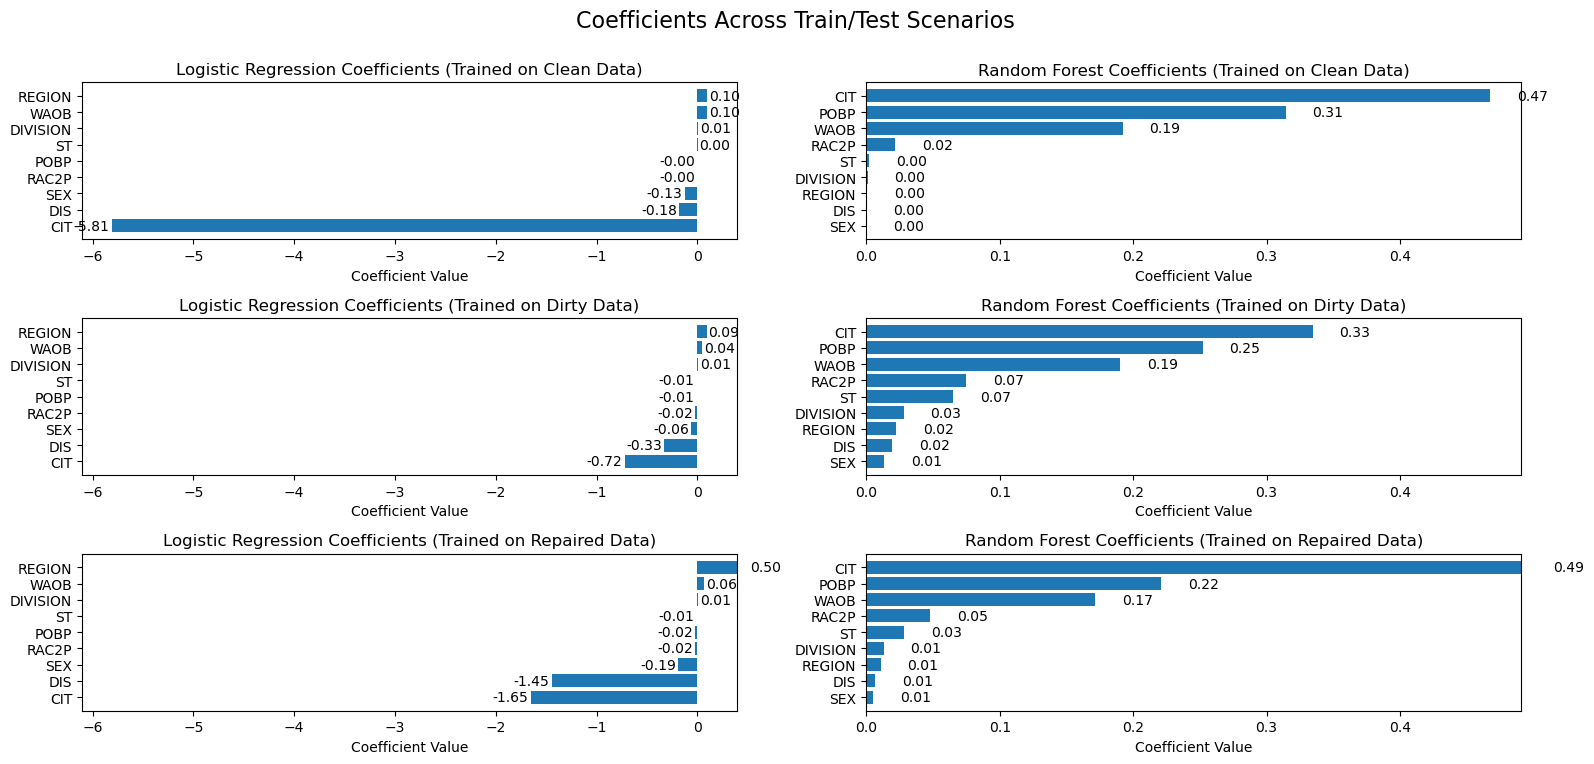

In [163]:
fig, axes = plt.subplots(3, 2, figsize=(16, 8))
fig.suptitle("Coefficients Across Train/Test Scenarios", fontsize=16)

# Plot into each subplot
plot_coefficients(
    logreg_train_clean.coef_[0], clean_feature_names, 
    "Logistic Regression Coefficients (Trained on Clean Data)", ax=axes[0, 0])



plot_coefficients(
    rf_train_clean.feature_importances_, clean_feature_names, 
    "Random Forest Coefficients (Trained on Clean Data)", ax=axes[0,1])

plot_coefficients(
    logreg_train_dirty.coef_[0], dirty_feature_names, 
    "Logistic Regression Coefficients (Trained on Dirty Data)", ax=axes[1, 0], sharex = axes[0, 0], sharey= axes[0,0])

plot_coefficients(
    rf_train_dirty.feature_importances_, dirty_feature_names, 
    "Random Forest Coefficients (Trained on Dirty Data)", ax=axes[1, 1], sharex=axes[0,1], sharey=axes[0,1])


plot_coefficients(
    logreg_train_repaired.coef_[0], dirty_feature_names, 
    "Logistic Regression Coefficients (Trained on Repaired Data)", ax=axes[2, 0], sharex = axes[0, 0], sharey= axes[0,0])

plot_coefficients(
    rf_train_repaired.feature_importances_, dirty_feature_names, 
    "Random Forest Coefficients (Trained on Repaired Data)", ax=axes[2, 1], sharex=axes[0,1], sharey=axes[0,1])

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig("lr_rf_coefficients.png")
plt.show()

<Figure size 1200x800 with 0 Axes>

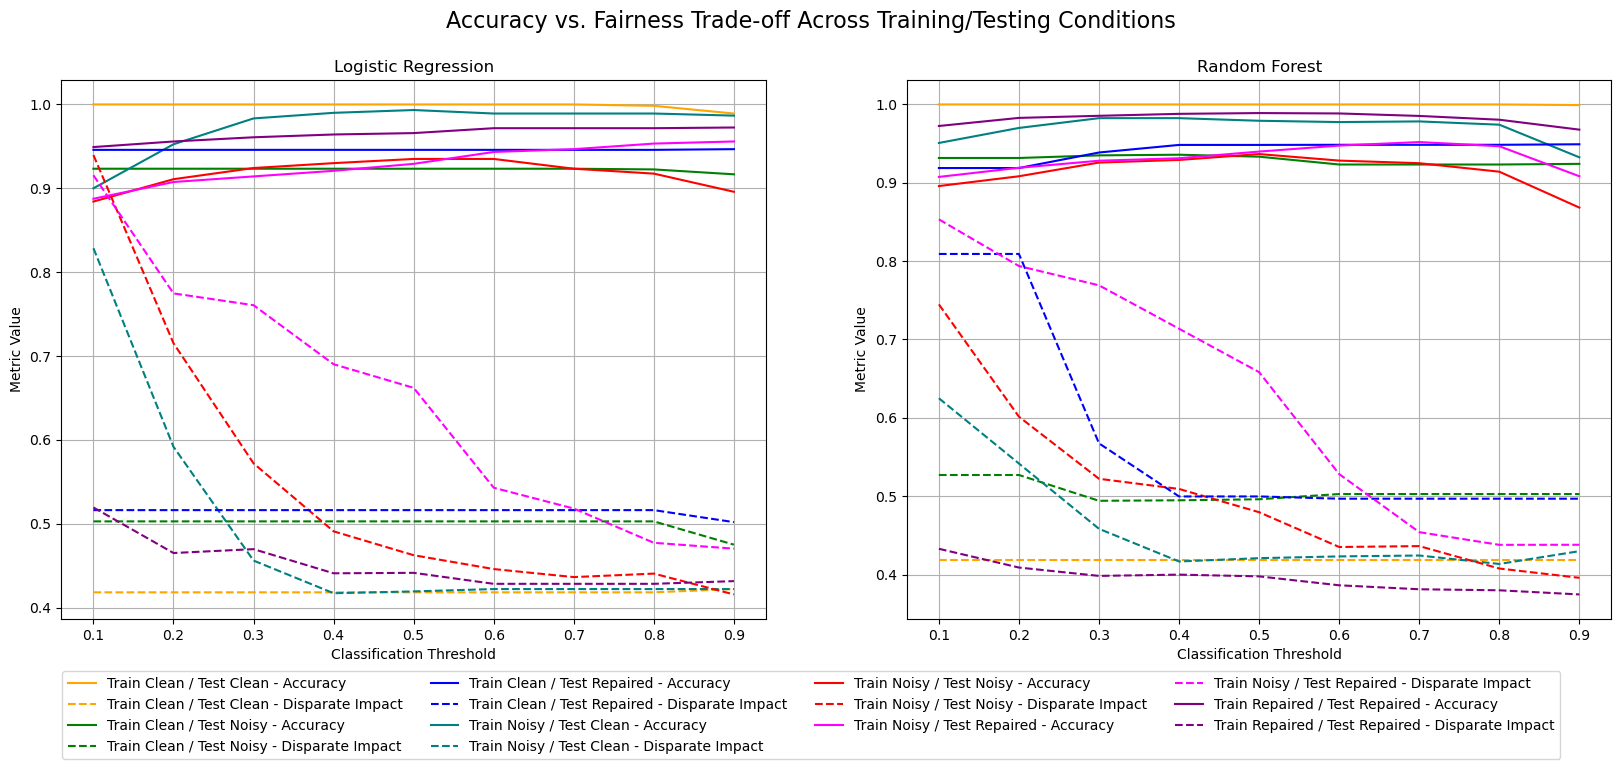

In [179]:
# Evaluate fairness metrics for different prediction thresholds
def fairness_by_threshold(model, X_test, y_test, sensitive_attr, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0.1, 0.9, 9)
    
    results = {}
    
    for threshold in thresholds:
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)
        
        dp = demographic_parity(y_pred, sensitive_attr)
        tpr, fpr = equalized_odds(y_test, y_pred, sensitive_attr)
        di = disparate_impact_ratio(y_pred, sensitive_attr)
        spd = statistical_parity_difference(y_pred, sensitive_attr)
        
        # Calculate accuracy at this threshold
        acc = accuracy_score(y_test, y_pred)
        
        results[threshold] = {
            'accuracy': acc,
            'demographic_parity': dp,
            'equalized_odds_tpr': tpr,
            'equalized_odds_fpr': fpr,
            'disparate_impact': di,
            'statistical_parity_diff': spd
        }
    
    return results

def plotThresholds(model_name, model_train_clean, model_train_dirty, model_train_repaired, X_test_clean, y_test_clean, s_test_clean, X_test_dirty, y_test_dirty, s_test_dirty, X_test_repaired, y_test_repaired, s_test_repaired, ax ):
    
    # Apply to all four model combinations
    clean_clean_thresholds = fairness_by_threshold(model_train_clean, X_test_clean, y_test_clean, s_test_clean)
    clean_dirty_thresholds = fairness_by_threshold(model_train_clean, X_test_dirty, y_test_dirty, s_test_dirty)
    dirty_clean_thresholds = fairness_by_threshold(model_train_dirty, X_test_clean, y_test_clean, s_test_clean)
    dirty_dirty_thresholds = fairness_by_threshold(model_train_dirty, X_test_dirty, y_test_dirty, s_test_dirty)
    clean_repaired_thresholds = fairness_by_threshold(model_train_clean, X_test_repaired, y_test_repaired, s_test_repaired)
    dirty_repaired_thresholds = fairness_by_threshold(model_train_dirty, X_test_repaired, y_test_repaired, s_test_repaired)
    repaired_repaired_thresholds = fairness_by_threshold(model_train_repaired, X_test_repaired, y_test_repaired, s_test_repaired)

    # Plot trade-offs: accuracy vs disparate impact for each
    thresholds = list(clean_clean_thresholds.keys())

    # Prepare metrics
    clean_clean_acc = [clean_clean_thresholds[t]['accuracy'] for t in thresholds]
    clean_clean_di = [clean_clean_thresholds[t]['disparate_impact'] for t in thresholds]

    clean_dirty_acc = [clean_dirty_thresholds[t]['accuracy'] for t in thresholds]
    clean_dirty_di = [clean_dirty_thresholds[t]['disparate_impact'] for t in thresholds]

    dirty_clean_acc = [dirty_clean_thresholds[t]['accuracy'] for t in thresholds]
    dirty_clean_di = [dirty_clean_thresholds[t]['disparate_impact'] for t in thresholds]

    dirty_dirty_acc = [dirty_dirty_thresholds[t]['accuracy'] for t in thresholds]
    dirty_dirty_di = [dirty_dirty_thresholds[t]['disparate_impact'] for t in thresholds]

    clean_repaired_acc = [clean_repaired_thresholds[t]['accuracy'] for t in thresholds]
    clean_repaired_di = [clean_repaired_thresholds[t]['disparate_impact'] for t in thresholds]

    dirty_repaired_acc = [dirty_repaired_thresholds[t]['accuracy'] for t in thresholds]
    dirty_repaired_di = [dirty_repaired_thresholds[t]['disparate_impact'] for t in thresholds]
    
    repaired_repaired_acc = [repaired_repaired_thresholds[t]['accuracy'] for t in thresholds]
    repaired_repaired_di = [repaired_repaired_thresholds[t]['disparate_impact'] for t in thresholds]
    
    p0, = ax.plot(thresholds, clean_clean_acc, 'orange', linestyle='-',label='Train Clean / Test Clean - Accuracy')
    p1, = ax.plot(thresholds, clean_clean_di, 'orange', linestyle='--', label='Train Clean / Test Clean - Disparate Impact')

    p2, = ax.plot(thresholds, clean_dirty_acc, 'g-', label='Train Clean / Test Noisy - Accuracy')
    p3, = ax.plot(thresholds, clean_dirty_di, 'g--', label='Train Clean / Test Noisy - Disparate Impact')

    p4, = ax.plot(thresholds, dirty_clean_acc, 'teal', linestyle='-', label='Train Noisy / Test Clean - Accuracy')
    p5, = ax.plot(thresholds, dirty_clean_di, 'teal', linestyle='--', label='Train Noisy / Test Clean - Disparate Impact')

    p6, = ax.plot(thresholds, dirty_dirty_acc, 'r-', label='Train Noisy / Test Noisy - Accuracy')
    p7, = ax.plot(thresholds, dirty_dirty_di, 'r--', label='Train Noisy / Test Noisy - Disparate Impact')

    p8, = ax.plot(thresholds, clean_repaired_acc, 'blue', linestyle='-', label='Train Clean / Test Repaired - Accuracy')
    p9, = ax.plot(thresholds, clean_repaired_di, 'blue', linestyle='--', label='Train Clean / Test Repaired - Disparate Impact')

    p10, = ax.plot(thresholds, dirty_repaired_acc, 'magenta', linestyle="-", label='Train Noisy / Test Repaired - Accuracy')
    p11, = ax.plot(thresholds, dirty_repaired_di, 'magenta', linestyle = "--", label='Train Noisy / Test Repaired - Disparate Impact')
    
    p12, = ax.plot(thresholds, repaired_repaired_acc, 'purple', linestyle="-", label='Train Repaired / Test Repaired - Accuracy')
    p13, = ax.plot(thresholds, repaired_repaired_di, 'purple', linestyle = "--", label='Train Repaired / Test Repaired - Disparate Impact')
    
    ax.set_xlabel('Classification Threshold')
    ax.set_ylabel('Metric Value')
    ax.set_title(model_name)
    
    ax.grid(True)
    handles = [p0, p1, p2, p3, p8, p9, p4, p5, p6, p7,  p10, p11, p12, p13]
    labels = ['Train Clean / Test Clean - Accuracy',
    'Train Clean / Test Clean - Disparate Impact',
    'Train Clean / Test Noisy - Accuracy',
    'Train Clean / Test Noisy - Disparate Impact',
    'Train Clean / Test Repaired - Accuracy',
    'Train Clean / Test Repaired - Disparate Impact',
    'Train Noisy / Test Clean - Accuracy',
    'Train Noisy / Test Clean - Disparate Impact',
    'Train Noisy / Test Noisy - Accuracy',
    'Train Noisy / Test Noisy - Disparate Impact',
#     'Train Clean / Test Repaired - Accuracy',
#     'Train Clean / Test Repaired - Disparate Impact',
    'Train Noisy / Test Repaired - Accuracy',
    'Train Noisy / Test Repaired - Disparate Impact',
    'Train Repaired / Test Repaired - Accuracy',
    'Train Repaired / Test Repaired - Disparate Impact']
    return  handles, labels

# Plot
plt.figure(figsize=(12, 8))
    
fig, axes = plt.subplots(1, 2, figsize=(20, 7),  sharex=True)
fig.suptitle("Accuracy vs. Fairness Trade-off Across Training/Testing Conditions", fontsize=16)

plotThresholds("Logistic Regression", logreg_train_clean, logreg_train_dirty, logreg_train_repaired, X_test_clean, y_test_clean, s_test_clean, X_test_dirty, y_test_dirty, s_test_dirty, X_test_repaired, y_test_repaired, s_test_repaired, ax=axes[0])

fig_handles, fig_labels = plotThresholds("Random Forest", rf_train_clean, rf_train_dirty, rf_train_repaired, X_test_clean, y_test_clean, s_test_clean, X_test_dirty, y_test_dirty, s_test_dirty, X_repaired, y_repaired, s_repaired, ax=axes[1])

fig.legend(fig_handles, fig_labels, bbox_to_anchor=[0.5, -0.1], loc='lower center', fancybox=True, ncol = 4)

plt.savefig("tradeoff.png", bbox_inches='tight')
plt.show()

<Figure size 1200x800 with 0 Axes>

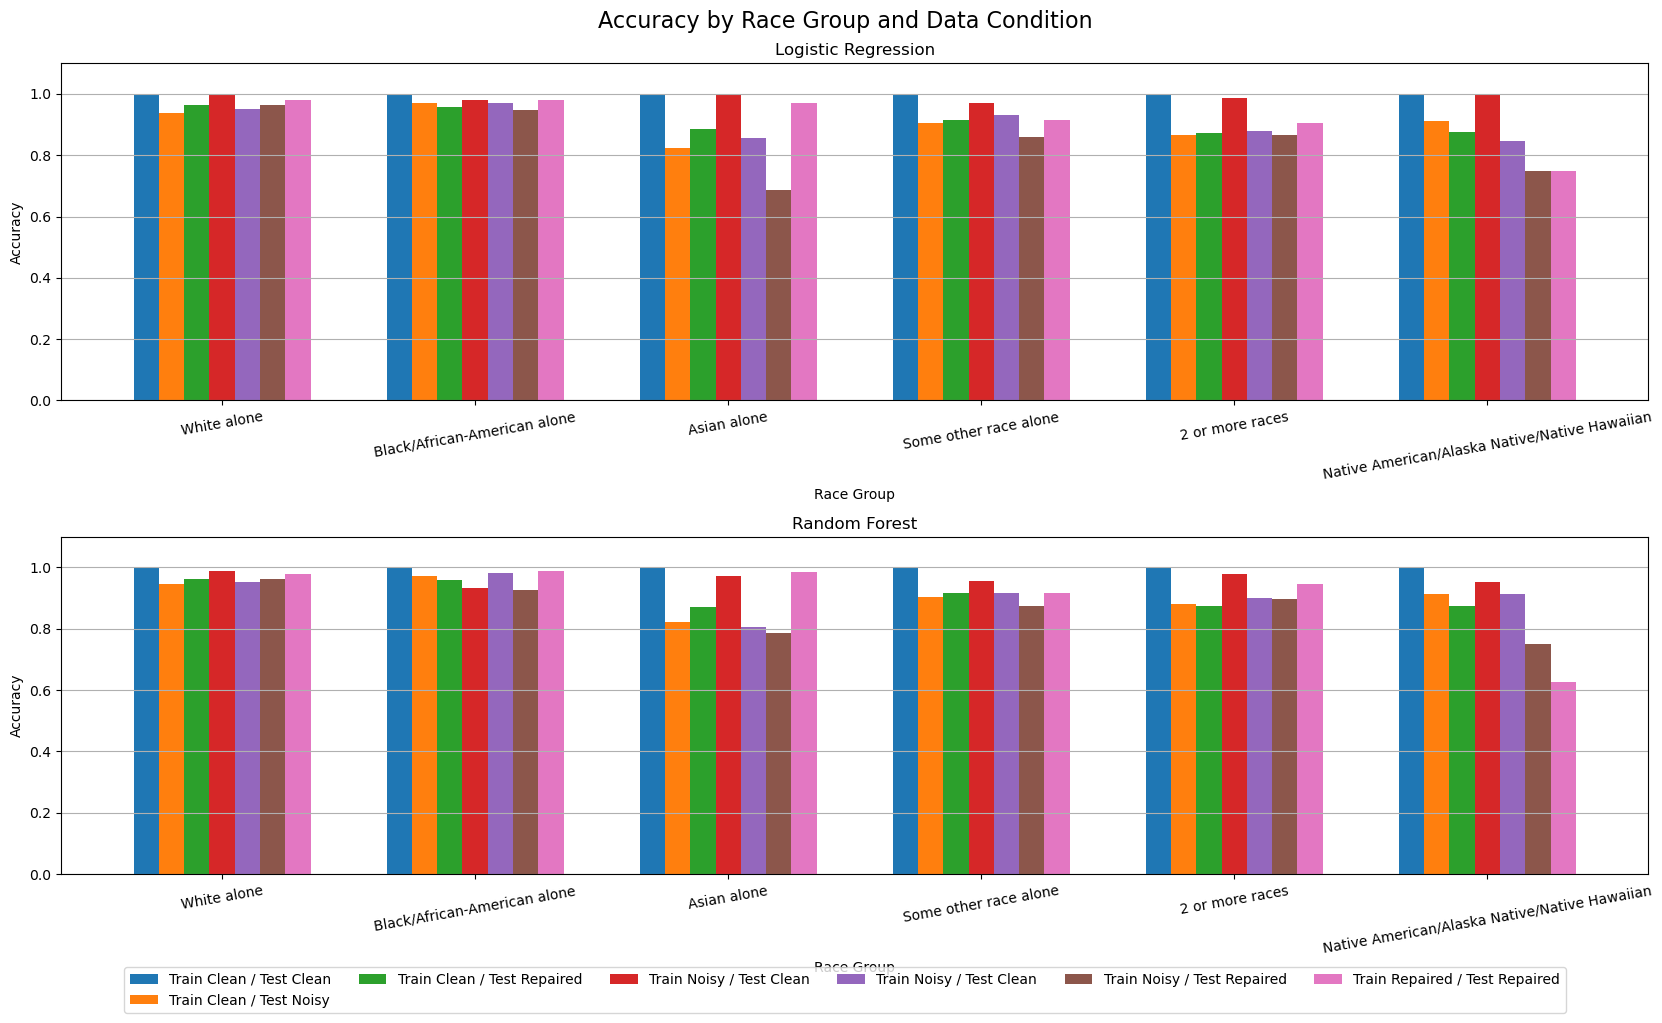

In [167]:
# Function to analyze model performance by group
# 1: White alone, 2: Black or African American alone, 3: American Indian alone, 4: Alaska Native alone, 5: American Indian and Alaskan Native tribes
# 6: Asian alone, 7: Native Hawaiian alone, 8: Some other race alone, 9: 2 or more races

#combined 3,4,5,7 -> 10

def analyze_by_group(y_true, y_pred, sensitive_attr):
    groups = sensitive_attr.unique()
    results = {}
    for group in groups:
        mask = (sensitive_attr == group)
        y_true_group = y_true[mask]
        y_pred_group = y_pred[mask]
        
        if len(y_true_group) < 5:
            continue
        
        results[group] = {
            'accuracy': accuracy_score(y_true_group, y_pred_group),
            'group_size': len(y_true_group),
            'percent_positive_predictions': y_pred_group.mean() * 100,
            'percent_positive_actual': y_true_group.mean() * 100,
            'confusion_matrix': confusion_matrix(y_true_group, y_pred_group).tolist()
        }
    return results
def plot_group_performance (model_name, y_test_clean, y_test_dirty, y_test_repaired, y_pred_train_clean_test_clean, y_pred_train_clean_test_dirty, y_pred_train_dirty_test_clean, y_pred_train_dirty_test_dirty, y_pred_train_clean_test_repaired, y_pred_train_dirty_test_repaired, y_pred_train_repaired_test_repaired, s_test_clean, s_test_dirty, s_test_repaired, ax):

    # Evaluate predictions from each model configuration
    clean_clean_by_group = analyze_by_group(y_test_clean, y_pred_train_clean_test_clean, s_test_clean)
    clean_dirty_by_group = analyze_by_group(y_test_dirty, y_pred_train_clean_test_dirty, s_test_dirty)
    dirty_clean_by_group = analyze_by_group(y_test_clean, y_pred_train_dirty_test_clean, s_test_clean)
    dirty_dirty_by_group = analyze_by_group(y_test_dirty, y_pred_train_dirty_test_dirty, s_test_dirty)
    clean_repaired_by_group = analyze_by_group(y_test_repaired, y_pred_train_clean_test_repaired, s_test_repaired)
    dirty_repaired_by_group = analyze_by_group(y_test_repaired, y_pred_train_dirty_test_repaired, s_test_repaired)
    repaired_repaired_by_group = analyze_by_group(y_test_repaired, y_pred_train_repaired_test_repaired, s_test_repaired)
    
    # Collect all group names
    groups = sorted(set(clean_clean_by_group.keys()) |
                    set(clean_dirty_by_group.keys()) |
                    set(dirty_clean_by_group.keys()) |
                    set(dirty_dirty_by_group.keys()) |
                    set(clean_repaired_by_group.keys()) |
                    set(dirty_repaired_by_group.keys()) |
                    set(repaired_repaired_by_group.keys())
                   )

    #Extract accuracy by group for each configuration
    clean_clean_acc = [clean_clean_by_group.get(g, {}).get('accuracy', 0) for g in groups]
    clean_dirty_acc = [clean_dirty_by_group.get(g, {}).get('accuracy', 0) for g in groups]
    dirty_clean_acc = [dirty_clean_by_group.get(g, {}).get('accuracy', 0) for g in groups]
    dirty_dirty_acc = [dirty_dirty_by_group.get(g, {}).get('accuracy', 0) for g in groups]
    clean_repaired_acc = [clean_repaired_by_group.get(g, {}).get('accuracy', 0) for g in groups]
    dirty_repaired_acc = [dirty_repaired_by_group.get(g, {}).get('accuracy', 0) for g in groups]
    repaired_repaired_acc = [repaired_repaired_by_group.get(g, {}).get('accuracy', 0) for g in groups]

    # Plot
    x = np.arange(len(groups))
    width = 0.1
    
    races_new = {1:"White alone", 2: "Black/African-American alone", 6: "Asian alone", 8: "Some other race alone", 9: "2 or more races", 10: "Native American/Alaska Native/Native Hawaiian"}

#     plt.figure(figsize=(18, 6))
    p0 = ax.bar(x - 3*width, clean_clean_acc, width, label='Train Clean / Test Clean', linewidth=0, )
    p1 = ax.bar(x - 2*width, clean_dirty_acc, width, label='Train Clean / Test Noisy', linewidth=0)
    p4 = ax.bar(x - 1*width, clean_repaired_acc, width, label='Train Clean / Test Repaired', linewidth=0)

    p2 = ax.bar(x , dirty_clean_acc, width, label='Train Noisy / Test Clean', linewidth=0)
    p3 = ax.bar(x + 1*width, dirty_dirty_acc, width, label='Train Noisy / Test Noisy', linewidth=0)
    p5 = ax.bar(x + 2*width, dirty_repaired_acc, width, label='Train Noisy / Test Repaired', linewidth=0)

    p6 = ax.bar(x + 3*width, repaired_repaired_acc, width, label='Train Repaired / Test Repaired', linewidth=0)

    labels = ['Train Clean / Test Clean', 'Train Clean / Test Noisy','Train Clean / Test Repaired', 'Train Noisy / Test Clean', 'Train Noisy / Test Clean',  'Train Noisy / Test Repaired', 'Train Repaired / Test Repaired' ]
    ax.set_xticks(x, [races_new[i] for i in groups])
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.set_xlabel('Race Group')
    ax.set_ylabel('Accuracy')
    ax.grid(True, axis='y')
    ax.set_ylim(0, 1.1)
    ax.tick_params(axis='x', labelrotation=10) 


    ax.set_title(model_name)
    # plt.title('Logistic Regression Accuracy by Race Group and Data Condition')
    return [p0,p1,p4, p2,p3,p5, p6], labels


plt.figure(figsize=(12, 8))


fig, axes = plt.subplots(2,1, figsize=(17, 10),  sharex=True)

# def plot_group_performance (model_name, y_test_clean, y_test_dirty, y_repaired, y_pred_train_clean_test_clean, y_pred_train_clean_test_dirty, y_pred_train_dirty_test_clean, y_pred_train_dirty_test_dirty, y_pred_train_clean_test_repaired, y_pred_train_dirty_test_repaired, s_test_clean, s_test_dirty, s_repaired, ax):
    
#     y_pred_rf_train_clean_test_clean
    
plot_group_performance("Logistic Regression", y_test_clean, y_test_dirty, y_test_repaired, y_pred_logreg_train_clean_test_clean, y_pred_logreg_train_clean_test_dirty, y_pred_logreg_train_dirty_test_clean, y_pred_logreg_train_dirty_test_dirty, y_pred_logreg_train_clean_test_repaired, y_pred_logreg_train_dirty_test_repaired, y_pred_logreg_train_repaired_test_repaired, s_test_clean, s_test_dirty, s_test_repaired, ax=axes[0])

fig_handles, fig_labels = plot_group_performance("Random Forest", y_test_clean, y_test_dirty, y_test_repaired, y_pred_rf_train_clean_test_clean, y_pred_rf_train_clean_test_dirty, y_pred_rf_train_dirty_test_clean, y_pred_rf_train_dirty_test_dirty, y_pred_rf_train_clean_test_repaired, y_pred_rf_train_dirty_test_repaired, y_pred_rf_train_repaired_test_repaired, s_test_clean, s_test_dirty, s_test_repaired, ax=axes[1])

fig.legend(fig_handles, fig_labels, bbox_to_anchor=[0.5, -.03], loc='lower center', fancybox=True, ncol = 6)

fig.suptitle("Accuracy by Race Group and Data Condition", fontsize=16)
plt.savefig("accuracy_by_race_data.png", bbox_inches='tight')
# plt.legend()
plt.tight_layout()
plt.show()



<Figure size 1200x800 with 0 Axes>

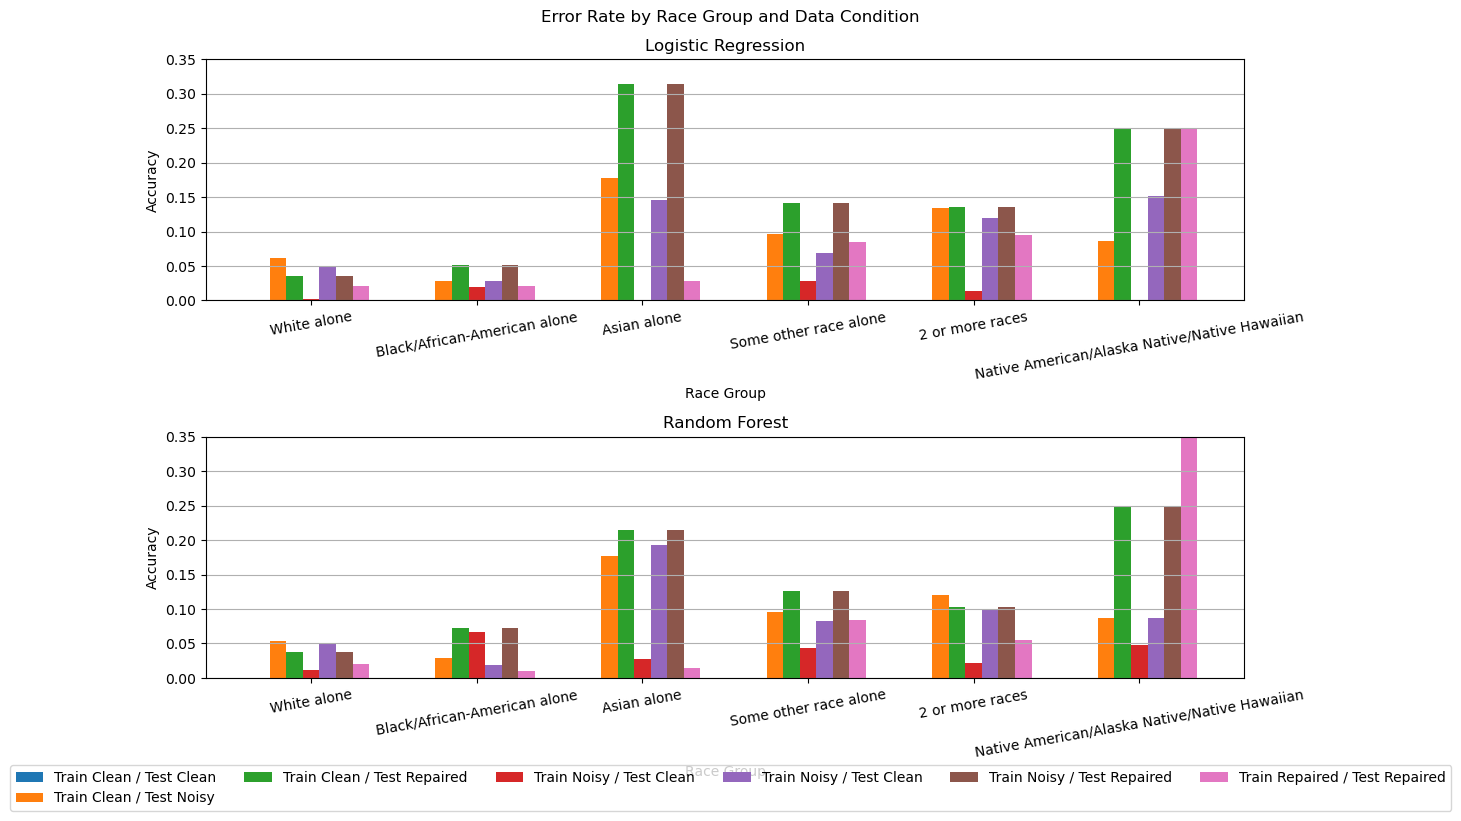

In [171]:
# Function to identify and analyze misclassified examples
def analyze_misclassifications(X_test, y_test, y_pred, sensitive_attr):
    misclassified = (y_test != y_pred)
    X_misclassified = X_test[misclassified]
    y_true_misclassified = y_test[misclassified]
    s_misclassified = sensitive_attr[misclassified]
    
    group_counts = s_misclassified.value_counts().to_dict()
    total_by_group = sensitive_attr.value_counts().to_dict()
    
    error_rates = {g: group_counts.get(g, 0) / total_by_group.get(g, 1) for g in total_by_group}
    
    misclassified_stats = X_misclassified.describe()
    overall_stats = X_test.describe()
    
    return {
        'total_misclassified': misclassified.sum(),
        'error_rate': misclassified.mean(),
        'group_error_counts': group_counts,
        'group_error_rates': error_rates,
        'misclassified_feature_stats': misclassified_stats,
        'overall_feature_stats': overall_stats
    }
def misclassification_analysis(model_name, X_test_clean, X_test_dirty, X_test_repaired, y_test_clean, y_test_dirty, y_test_repaired, y_pred_train_clean_test_clean, y_pred_train_clean_test_dirty, y_pred_train_dirty_test_clean, y_pred_train_dirty_test_dirty, y_pred_train_clean_test_repaired, y_pred_train_dirty_test_repaired, y_pred_train_repaired_test_repaired, ax):
    # Analyze all four logistic regression scenarios
    clean_clean_errors = analyze_misclassifications(X_test_clean, y_test_clean, y_pred_train_clean_test_clean, s_test_clean)
    clean_dirty_errors = analyze_misclassifications(X_test_dirty, y_test_dirty, y_pred_train_clean_test_dirty, s_test_dirty)
    dirty_clean_errors = analyze_misclassifications(X_test_clean, y_test_clean, y_pred_train_dirty_test_clean, s_test_clean)
    dirty_dirty_errors = analyze_misclassifications(X_test_dirty, y_test_dirty, y_pred_train_dirty_test_dirty, s_test_dirty)
    clean_repaired_errors = analyze_misclassifications(X_test_repaired, y_test_repaired, y_pred_train_clean_test_repaired, s_test_repaired)
    dirty_repaired_errors = analyze_misclassifications(X_test_repaired, y_test_repaired, y_pred_train_dirty_test_repaired, s_test_repaired)
    repaired_repaired_errors = analyze_misclassifications(X_test_repaired, y_test_repaired, y_pred_train_repaired_test_repaired, s_test_repaired)

    # Collect all race groups
    groups = sorted(set(clean_clean_errors['group_error_rates'].keys()) |
                    set(clean_dirty_errors['group_error_rates'].keys()) |
                    set(dirty_clean_errors['group_error_rates'].keys()) |
                    set(dirty_dirty_errors['group_error_rates'].keys()) |
                    set(clean_repaired_errors['group_error_rates'].keys()) |
                    set(dirty_repaired_errors['group_error_rates'].keys()) |
                    set(repaired_repaired_errors['group_error_rates'].keys())
                   )
    # Extract error rates by group
    clean_clean_errors = [clean_clean_errors['group_error_rates'].get(g, 0) for g in groups]
    clean_dirty_errors = [clean_dirty_errors['group_error_rates'].get(g, 0) for g in groups]
    dirty_clean_errors = [dirty_clean_errors['group_error_rates'].get(g, 0) for g in groups]
    dirty_dirty_errors = [dirty_dirty_errors['group_error_rates'].get(g, 0) for g in groups]
    clean_repaired_errors = [dirty_repaired_errors['group_error_rates'].get(g, 0) for g in groups]
    dirty_repaired_errors = [dirty_repaired_errors['group_error_rates'].get(g, 0) for g in groups]
    repaired_repaired_errors = [repaired_repaired_errors['group_error_rates'].get(g, 0) for g in groups]

    # Plot grouped bar chart
    x = np.arange(len(groups))
    width = 0.1
    
    races_new = {1:"White alone", 2: "Black/African-American alone", 6: "Asian alone", 8: "Some other race alone", 9: "2 or more races", 10: "Native American/Alaska Native/Native Hawaiian"}
    ax.set_xticks(x, [races_new[i] for i in groups])
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.tick_params(axis='x', labelrotation=10) 


    p0 = ax.bar(x - 3*width, clean_clean_errors, width, label='Train Clean / Test Clean')
    p1 = ax.bar(x - 2*width, clean_dirty_errors, width, label='Train Clean / Test Noisy')
    p4 = ax.bar(x - 1*width, clean_repaired_errors, width, label='Train Clean / Test Repaired')

    p2 = ax.bar(x , dirty_clean_errors, width, label='Train Noisy / Test Clean')
    p3 = ax.bar(x + 1*width, dirty_dirty_errors, width, label='Train Noisy / Test Noisy')
    p5 = ax.bar(x + 2*width, dirty_repaired_errors, width, label='Train Noisy / Test Repaired')
    p6 = ax.bar(x + 3*width, repaired_repaired_errors, width, label='Train Repaired / Test Repaired')

    ax.set_xlabel('Race Group')
    ax.set_ylabel('Error Rate')
    ax.set_title(model_name)
    labels = ['Train Clean / Test Clean', 'Train Clean / Test Noisy', 'Train Clean / Test Repaired', 'Train Noisy / Test Clean', 'Train Noisy / Test Clean', 'Train Noisy / Test Repaired',  'Train Repaired / Test Repaired']
    ax.grid(True, axis='y')
    ax.set_ylim(0, 0.35)

    ax.set_xlabel('Race Group')
    ax.set_ylabel('Accuracy')
    ax.set_title(model_name)
    # plt.title('Logistic Regression Accuracy by Race Group and Data Condition')
    return [p0,p1,p4, p2,p3,p5, p6], labels


plt.figure(figsize=(12, 8))


fig, axes = plt.subplots(2,1, figsize=(12, 8),  sharex=True, sharey=True)
    
misclassification_analysis("Logistic Regression", X_test_clean, X_test_dirty, X_test_repaired, y_test_clean, y_test_dirty, y_test_repaired, y_pred_logreg_train_clean_test_clean, y_pred_logreg_train_clean_test_dirty, y_pred_logreg_train_dirty_test_clean, y_pred_logreg_train_dirty_test_dirty, y_pred_logreg_train_clean_test_repaired, y_pred_logreg_train_dirty_test_repaired, y_pred_logreg_train_repaired_test_repaired, ax=axes[0])

fig_handles, fig_labels = misclassification_analysis("Random Forest",  X_test_clean, X_test_dirty, X_test_repaired, y_test_clean, y_test_dirty, y_test_repaired, y_pred_rf_train_clean_test_clean, y_pred_rf_train_clean_test_dirty, y_pred_rf_train_dirty_test_clean, y_pred_rf_train_dirty_test_dirty, y_pred_rf_train_clean_test_repaired, y_pred_rf_train_dirty_test_repaired, y_pred_rf_train_repaired_test_repaired,  ax=axes[1])

plt.suptitle('Error Rate by Race Group and Data Condition')

# plt.xticks(x, groups)
plt.tight_layout()

fig.legend(fig_handles, fig_labels, bbox_to_anchor=[0.5, -.03], loc='lower center', fancybox=True, ncol = 6)
plt.savefig("error_rate_by_race.png", bbox_inches='tight')

plt.show()

In [186]:
pd.DataFrame(s_test_repaired).value_counts()

pd.DataFrame(y_test_repaired).value_counts()

RAC1P
1        828
9        126
2         97
8         71
6         70
10         8
Name: count, dtype: int64